In [34]:
#!pip install statsmodels

# Display plots directly in the notebook
%matplotlib inline


# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import patsy
#import statsmodels.api as sm


In [38]:
yelp_df = pd.read_csv('../data/yelp_SD_parks.csv')
rec_df = gpd.read_file('../data/rec_centers_datasd.geojson')
access_df = pd.read_excel('../data/hci_accesstoparks_469_ca_re_co_cd_pl_ct-7-3-2017-ada.xlsx')

In [39]:
access_df.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_fips,county_name,...,numerator,denominator,estimate,ll_95ci,ul_95ci,se,rse,ca_decile,ca_rr,version
0,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,78625.0,162250.0,48.459168,48.215988,48.702348,0.124071,0.256033,NaN,1.0,2017-07-03 11:02:07
1,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,11839.0,162250.0,7.296764,7.170210,7.423318,0.064568,0.884891,NaN,1.0,2017-07-03 11:02:07
2,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,12338.0,162250.0,7.604314,7.475335,7.733294,0.065806,0.865373,NaN,1.0,2017-07-03 11:02:07
3,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,4926.0,162250.0,3.036055,2.952568,3.119543,0.042596,1.403001,NaN,1.0,2017-07-03 11:02:07
4,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,17147.0,162250.0,10.568259,10.418666,10.717852,0.076323,0.722190,NaN,1.0,2017-07-03 11:02:07


In [37]:
access_df = access_df[['race_eth_name','geotypevalue','numerator',
                      'denominator','estimate']]
access_df

,race_eth_name,geotypevalue,numerator,denominator,estimate
0,AIAN,6.0,78625.0,162250.0,48.459168
1,AIAN,6.0,11839.0,162250.0,7.296764
2,AIAN,6.0,12338.0,162250.0,7.604314
3,AIAN,6.0,4926.0,162250.0,3.036055
4,AIAN,6.0,17147.0,162250.0,10.568259
...,...,...,...,...,...
543182,Total,14.0,477107.0,18051534.0,2.643027
543183,Total,14.0,384121.0,18051534.0,2.127913
543184,Total,14.0,1617679.0,18051534.0,8.961449
543185,Total,14.0,13282917.0,18051534.0,73.583314


In [18]:
yelp_SD = yelp_SD.drop(columns=['phone','id','url','longitude','latitude','is_closed'])
yelp_SD.head(yelp_SD, par)

,name,address,rating,review_count
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5,46
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5,242
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5,102
4,Bay View Park,"413 1st St Coronado, CA 92118",5.0,42


In [27]:
joint_df = gpd.read_file('../data/joint_use_datasd.geojson')

In [32]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

<AxesSubplot:>

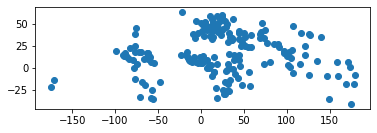

In [33]:
cities.plot()